In [1]:
import pandas as pd
import re
import spacy
import neuralcoref

ValueError: spacy.strings.StringStore size changed, may indicate binary incompatibility. Expected 112 from C header, got 88 from PyObject

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
neuralcoref.add_to_pipe(nlp)

In [ ]:
pip install wikipediaapi
import wikipediaapi  
import pandas as pd


def wiki_scrape(topic):
    wiki_api = wikipediaapi.Wikipedia(language='en',
            extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic)
    if not page_name.exists():
        print('page does not exist')
        exit()
    page_links = [topic] + list(page_name.links.keys())
    working_links = [link for link in page_links
                     if wiki_api.page(link).exists()]
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = [link for link in working_links
               if len(wiki_api.page(link).text) > 20
               and not link.startswith(blacklist)]
    wiki_data = {'topic':topic, 'page':sources}
    wiki_data['text'] = [wiki_api.page(page).text for page in sources]
    wiki_data['link'] = [wiki_api.page(page).fullurl for page in sources]
    wiki_data['categories'] = [[y[9:] for y in
                               list(wiki_api.page(page).categories.keys())]
                               for page in sources]
    print ('Wikipedia pages scraped:', len(sources))
    wiki_scrape_df = pd.DataFrame(wiki_data)
    return wiki_scrape_df
 
wiki_data = wiki_scrape('coronavirus')


In [4]:
pd.read_csv("test1.csv").head()

,Unnamed: 0,topic,page,text,link,categories
0,0,coronavirus,coronavirus,Coronaviruses are a group of related viruses t...,https://en.wikipedia.org/wiki/Coronavirus,"['All articles with unsourced statements', 'An..."
1,1,coronavirus,2003 SARS outbreak,The 2002–2004 SARS outbreak involving severe a...,https://en.wikipedia.org/wiki/2002%E2%80%93200...,"['2000s medical outbreaks', '2002 disasters in..."
2,2,coronavirus,2012 Middle East respiratory syndrome coronavi...,"Since 2012, an outbreak of Middle East respira...",https://en.wikipedia.org/wiki/2012_Middle_East...,"['2010s medical outbreaks', '2012 health disas..."
3,3,coronavirus,2015 Middle East respiratory syndrome outbreak...,An outbreak of Middle East respiratory syndrom...,https://en.wikipedia.org/wiki/2015_Middle_East...,"['2010s medical outbreaks', '2015 disasters in..."
4,4,coronavirus,2018 Middle East respiratory syndrome outbreak,The 2018 Middle East respiratory syndrome outb...,https://en.wikipedia.org/wiki/2018_Middle_East...,"['2018 health disasters', '2018 in Saudi Arabi..."


In [5]:
wiki_data = pd.read_csv("test1.csv")

In [6]:
def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type



In [7]:
pairs = entity_pairs(wiki_data.loc[0,'text'])

Entity pairs extracted: 18


In [13]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

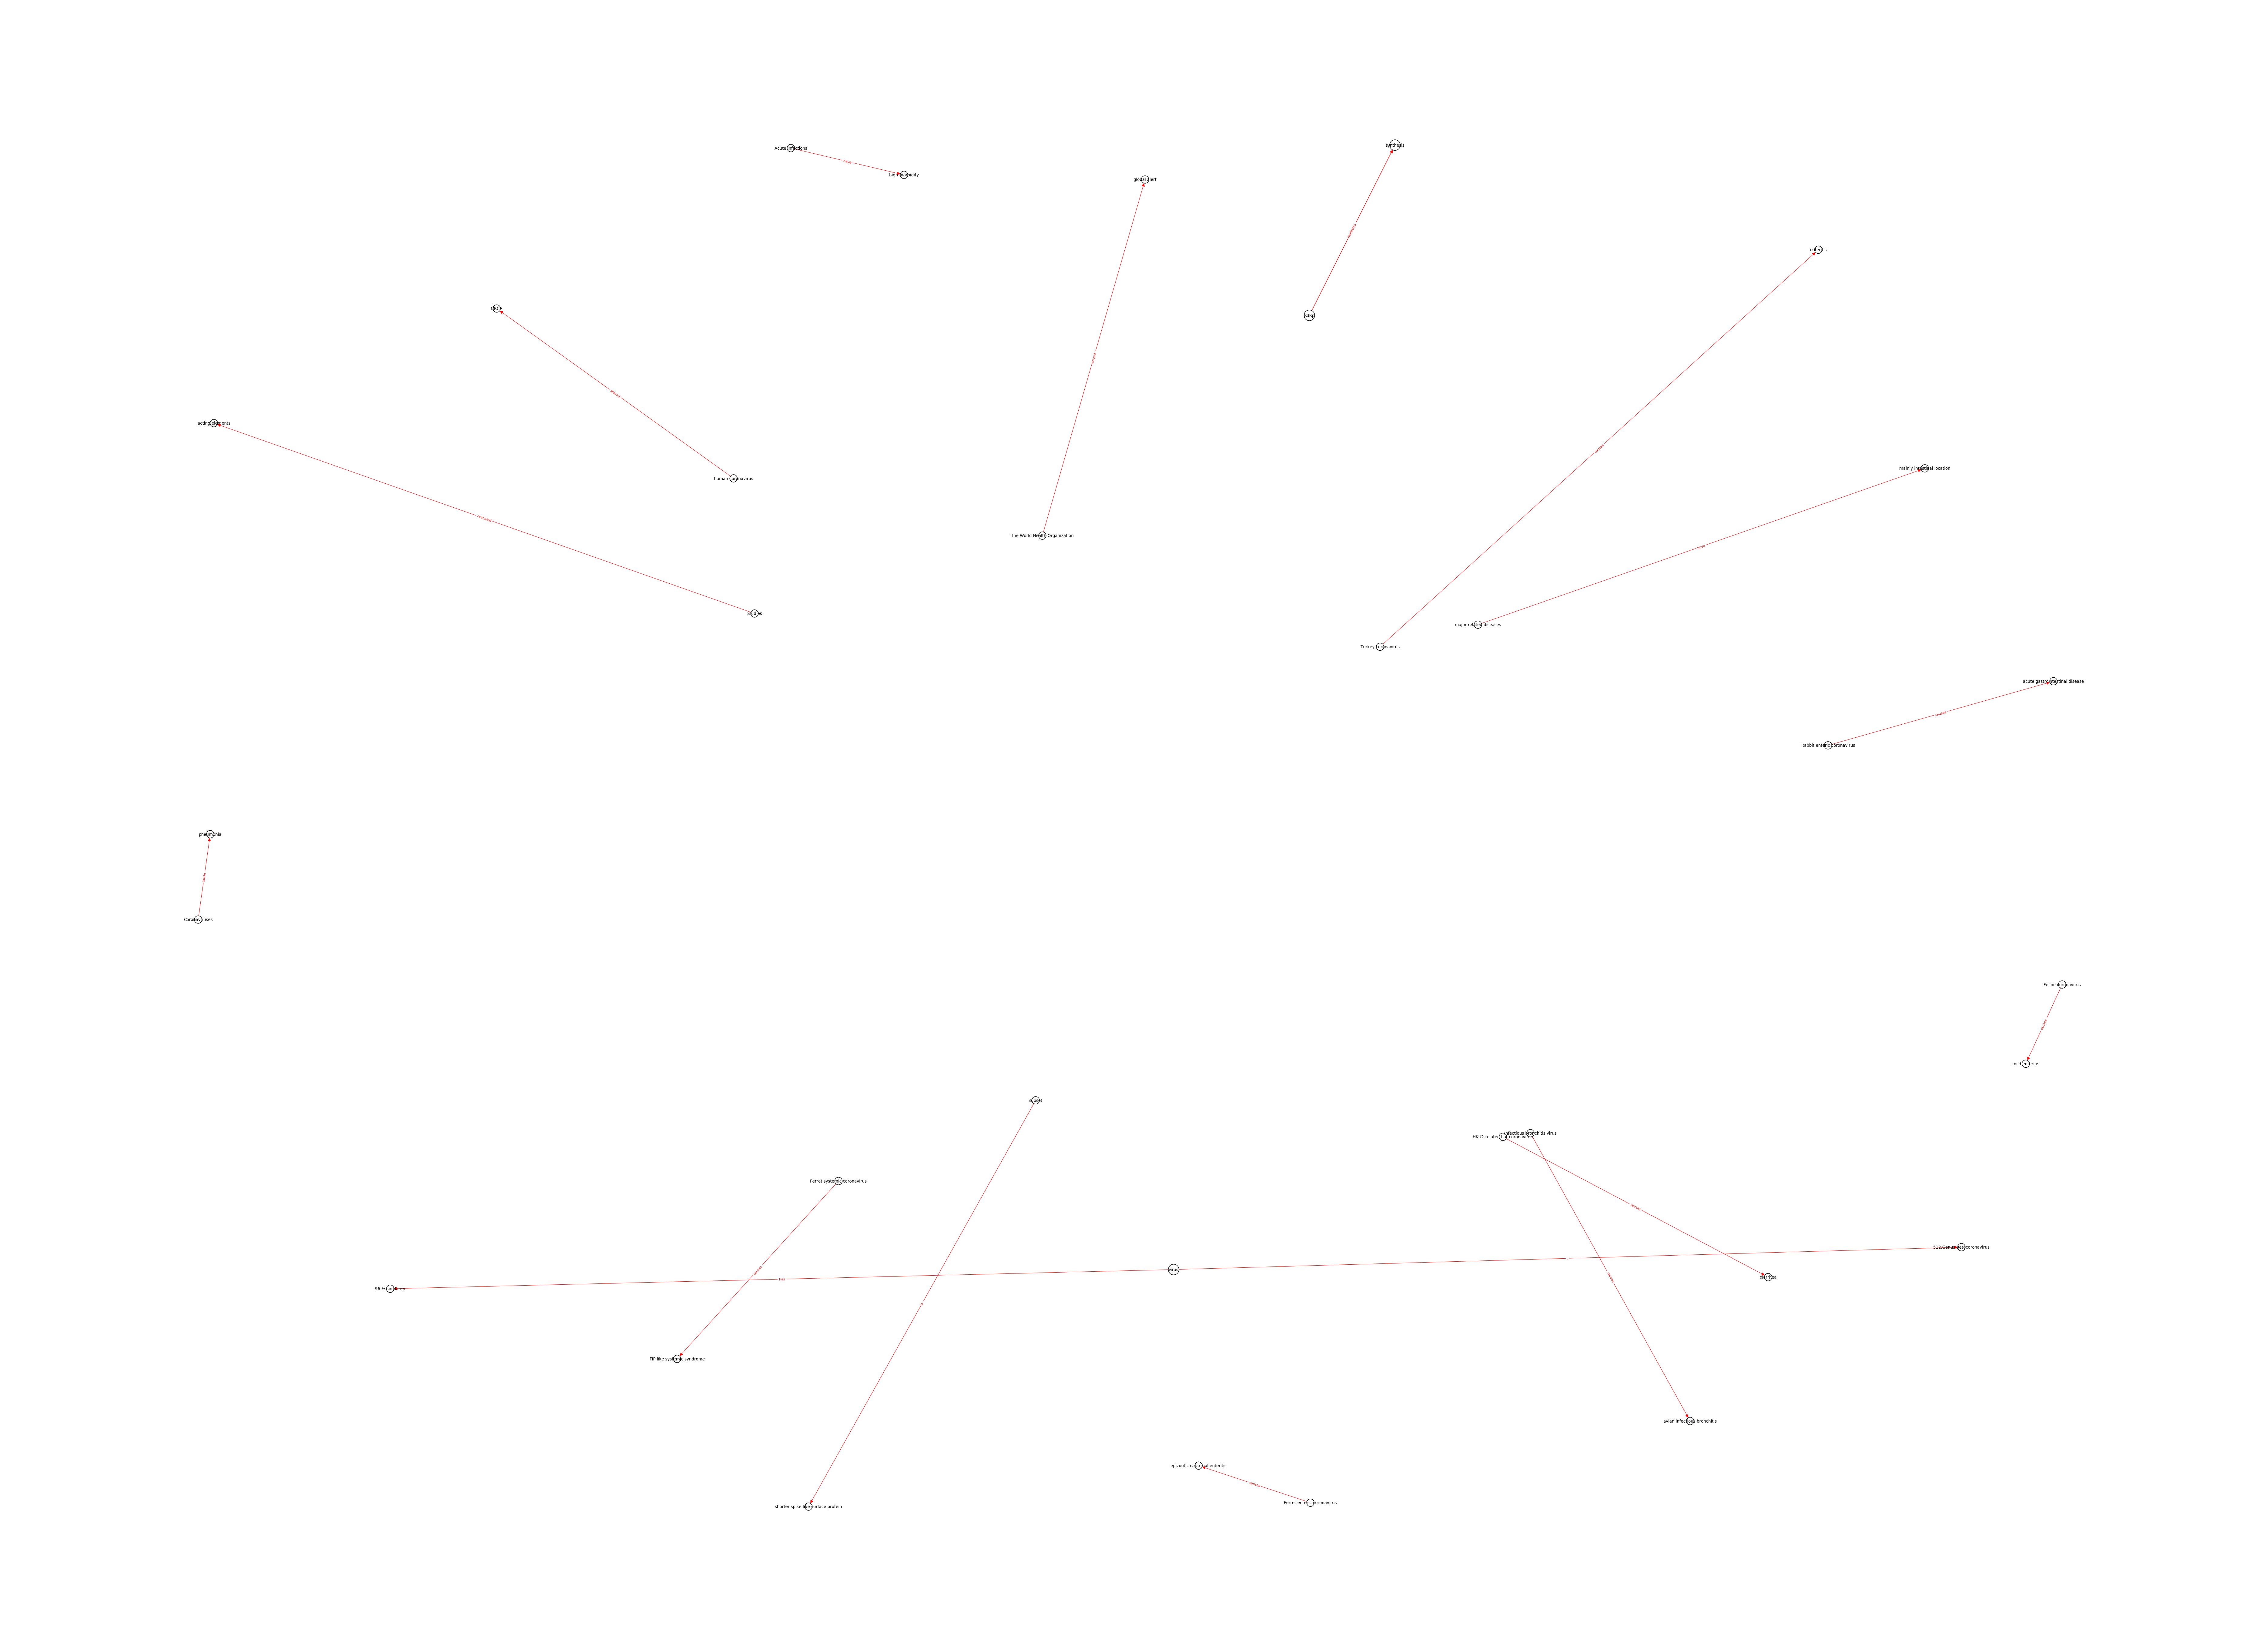

<Figure size 432x288 with 0 Axes>

In [14]:
draw_kg(pairs)

In [10]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    print(k_graph.out_edges(data=False))
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

[('subset', 'shorter spike like surface protein'), ('RdRp', 'synthesis'), ('RdRp', 'synthesis'), ('virus', '512.Genus Betacoronavirus'), ('virus', '96 % similarity'), ('human coronavirus', 'MRCA'), ('Coronaviruses', 'pneumonia'), ('The World Health Organization', 'global alert'), ('major related diseases', 'mainly intestinal location'), ('Acute infections', 'high morbidity'), ('HKU2-related bat coronavirus', 'diarrhea'), ('Infectious bronchitis virus', 'avian infectious bronchitis'), ('Feline coronavirus', 'mild enteritis'), ('Turkey coronavirus', 'enteritis'), ('Ferret enteric coronavirus', 'epizootic catarrhal enteritis'), ('Ferret systemic coronavirus', 'FIP like systemic syndrome'), ('Rabbit enteric coronavirus', 'acute gastrointestinal disease'), ('Studies', 'acting elements')]


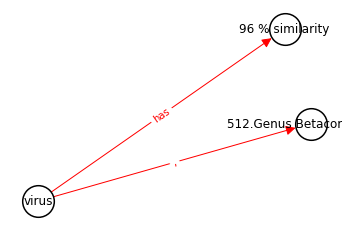

In [12]:
filter_graph(pairs, 'virus')